In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTENC,ADASYN
from sklearn.metrics import precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## 6. XGBoost

Para hacer uso del modelo XGBoost, nuevamente importamos el dataframe limpio del EDA.

In [4]:
df_final=pd.read_pickle("data_limpia.pkl") 

Para este modelo, no contamos con el parámetro `class_weight='balanced'`. Sin embargo, para clasificación binaria existe un parámetro en XGBoost equivalente que asigna pesos a la clase minoritaria como lo hace el parámetro con el que hemos venido trabajando. 

`scale_pos_weight` ajusta el peso de la clase minoritaria. Para esto debemos escribir `scale_pos_weight=n`, siendo n la proporción entre el número de elementos de la clase negativa y el número de elementos de la clase positiva, ambos de la variable objetivo por su puesto. Haremos uso de este parámetro, y luego se hará la respectiva comparación entre `SMOTE` y `ADASYN`

### 6.1 Modelo sin balanceo de clases

#### 6.1.1 Búsqueda del mejor parámetro

Primero, dividamos el dataset en las características y la variable objetivo:

In [5]:
X=df_final.drop(columns=['target'])
y=df_final['target']

Codificamos la variable objetivo:

In [6]:
y = y.map({
    'diseased': 1,
    'healthy': 0,
})

# Verificamos la codificación
print(y.value_counts())

target
0    70097
1    29903
Name: count, dtype: int64


Guardamos en una lista los nombres de las variables númericas, y en otra lista los nombres de las variables categóricas.

In [8]:
numerical_cols=['age', 'bmi','waist_size',
    'blood_pressure', 'cholesterol', 'heart_rate',
    'glucose', 'insulin','sleep_hours','work_hours','physical_activity','daily_steps',
    'calorie_intake', 'sugar_intake','water_intake','income',
    'screen_time', 'stress_level', 'mental_health_score', 'meals_per_day']

cat_cols=['gender', 'diet_type', 'occupation',
    'sleep_quality', 'mental_health_support', 'exercise_type',
    'device_usage', 'healthcare_access', 'insurance',
    'family_history', 'sunlight_exposure', 'alcohol_consumption', 
    'smoking_level', 'education_level', 'job_type', 'caffeine_intake', 'pet_owner']

Para el modelo XGBoost no es necesaria una estandarización de variables numéricas, y gracias al parámetro `enable_categorical=True`, tampoco se necesita una codificación de las categóricas. Para poder hacer uso de este parámetro hay que pasar las variables categóricas, que están en tipo `object`, a tipo `category`.

In [10]:
X[cat_cols] = X[cat_cols].astype('category')

Ahora, dividamos el dataset en un conjunto de entrenamiento y otro de prueba. Este último se reservará **únicamente para la evaluación del modelo con el mejor parámetro encontrado**. Para la búsqueda del mejor parámetro, se usará el conjunto de entrenamiento dividido en entrenamiento y validación.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

En el `pipeline` se ajustarán parámetros que controlan la profundidad de cada árbol de decisión (`max_depth`), el grado en que cada árbol puede corregir los errores de los árboles anteriores (`learning_rate`) y el número de árboles a considerar (`n_estimators`).

Además, la optimización computacional para este modelo se enfoca en el uso de la **GPU** por medio del parámetro `tree_method='gpu_hist'`.

In [ ]:
pipe=Pipeline([
    ("xgboost", XGBClassifier(random_state=42, tree_method='gpu_hist',  enable_categorical=True, use_label_encoder=False))  
])

param_grid_pipe={
    'xgboost__max_depth': [1, 2, 3, 4, 5],  # Rango para la profundidad del árbol
    'xgboost__learning_rate': [0.1, 0.2, 0.3],  # Rango para la tasa de aprendizaje
    'xgboost__n_estimators': [10, 50, 100],  # Número de árboles a entrenar
}

In [17]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1, verbose=1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Tiempo de ejecucion(segundos):87.32


In [18]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'xgboost__learning_rate': 0.3, 'xgboost__max_depth': 5, 'xgboost__n_estimators': 100}
Best cross-validation score: 0.02


In [19]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.70      0.99      0.82     17524
    diseased       0.29      0.01      0.03      7476

    accuracy                           0.70     25000
   macro avg       0.50      0.50      0.42     25000
weighted avg       0.58      0.70      0.58     25000



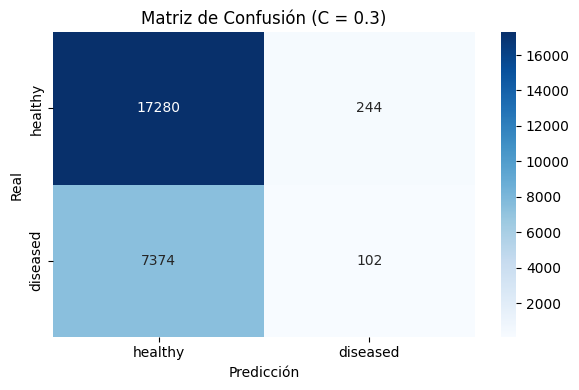

In [20]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

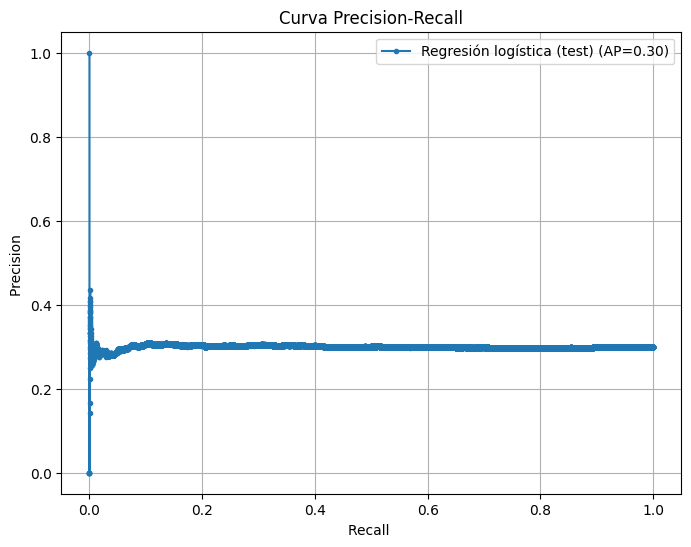

In [21]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'Regresión logística (test) (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

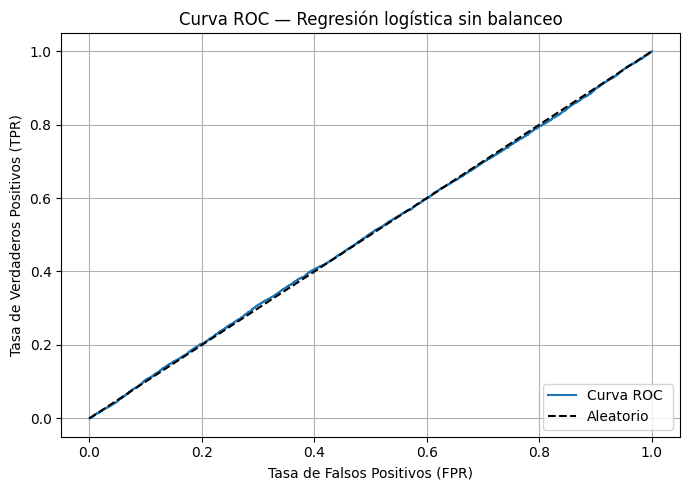

AUC (Área bajo la curva ROC): 0.5004


In [22]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Regresión logística sin balanceo')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

### 6.2 Modelo con balanceo por el parámetro `scale_pos_weight`

Como se dijo anteriormente, para poder otorgar pesos a la clase minoritaria con `scale_pos_weight` es necesario calcular la proporción emtre el número de elementos de la clase negativa y el número de elementos de la clase positiva.

Nuestro dataset cuenta con un desbalance del 70/30 aproximadamente, favoreciendo a la clase negativa, por lo que, el número a colocar es $7/3 \approx 2.3$.

In [24]:
pipe=Pipeline([
    ("xgboost", XGBClassifier(random_state=42,scale_pos_weight=2.3, tree_method='gpu_hist',  enable_categorical=True, use_label_encoder=False))  
])

param_grid_pipe={
    'xgboost__max_depth': [1, 2, 3, 4, 5],  # Rango para la profundidad del árbol
    'xgboost__learning_rate': [0.1, 0.2, 0.3],  # Rango para la tasa de aprendizaje
    'xgboost__n_estimators': [10, 50, 100],  # Número de árboles a entrenar
}

In [25]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1, verbose=1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Tiempo de ejecucion(segundos):82.07


In [26]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'xgboost__learning_rate': 0.3, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 100}
Best cross-validation score: 0.43


In [27]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.70      0.57      0.63     17524
    diseased       0.30      0.42      0.35      7476

    accuracy                           0.53     25000
   macro avg       0.50      0.50      0.49     25000
weighted avg       0.58      0.53      0.55     25000



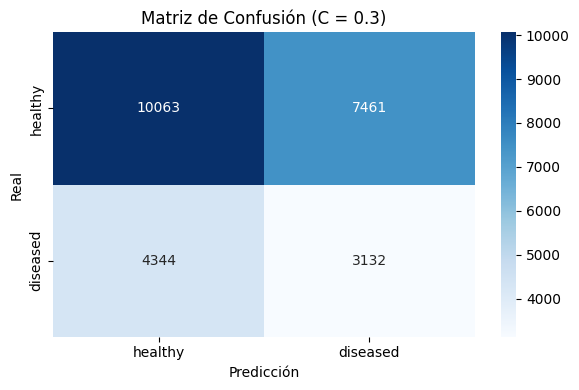

In [29]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

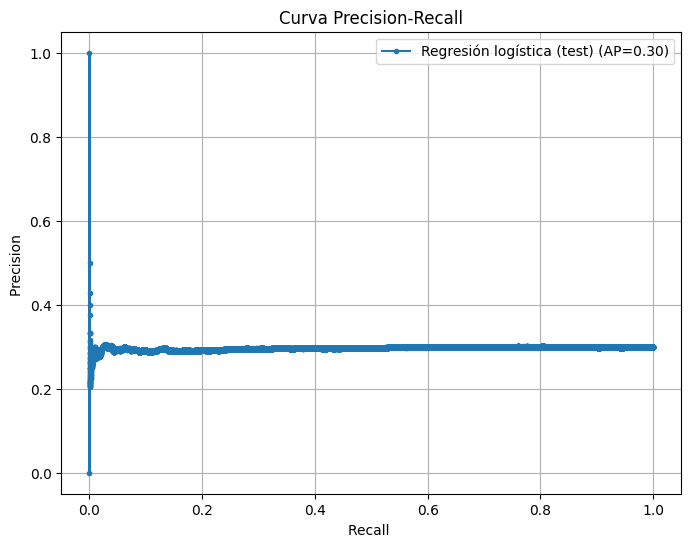

In [30]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'Regresión logística (test) (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

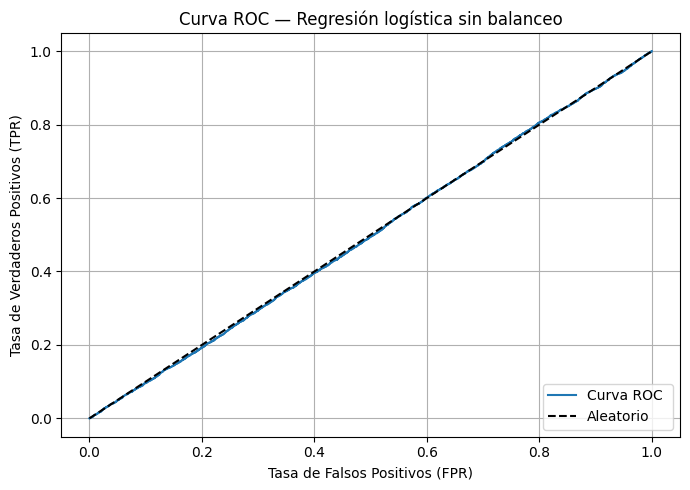

AUC (Área bajo la curva ROC): 0.4977


In [31]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Regresión logística sin balanceo')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

### 6.3 Modelo con balanceo por el por `SMOTE`

Nuevamente haremos uso del método `SMOTENC` para tratar con el desbalance de clases.

In [38]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"  # deja las numéricas igual
)


pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42, n_jobs=-1)),
    ("xgboost", XGBClassifier(random_state=42,tree_method='gpu_hist',use_label_encoder=False))
])

param_grid_pipe={
    'xgboost__max_depth': [1, 2, 3, 4, 5],  # Rango para la profundidad del árbol
    'xgboost__learning_rate': [0.1, 0.2, 0.3],  # Rango para la tasa de aprendizaje
    'xgboost__n_estimators': [10, 50, 100],  # Número de árboles a entrenar
}

In [39]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1, verbose=1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits


  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Tiempo de ejecucion(segundos):225.09


In [40]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 1, 'xgboost__n_estimators': 10}
Best cross-validation score: 0.09


In [41]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.70      1.00      0.82     17524
    diseased       0.00      0.00      0.00      7476

    accuracy                           0.70     25000
   macro avg       0.35      0.50      0.41     25000
weighted avg       0.49      0.70      0.58     25000



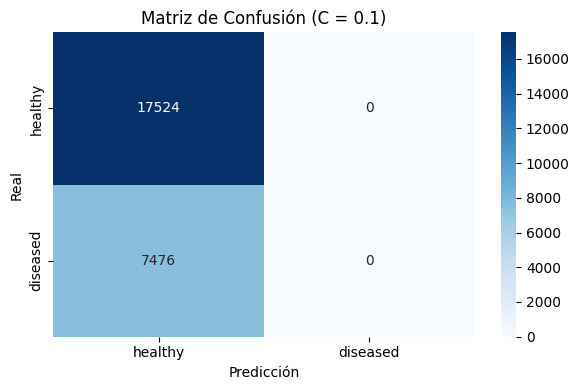

In [42]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

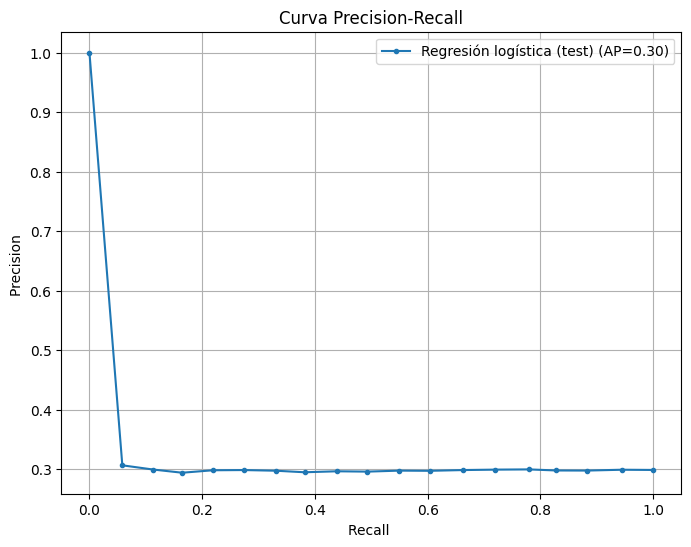

In [43]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'Regresión logística (test) (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

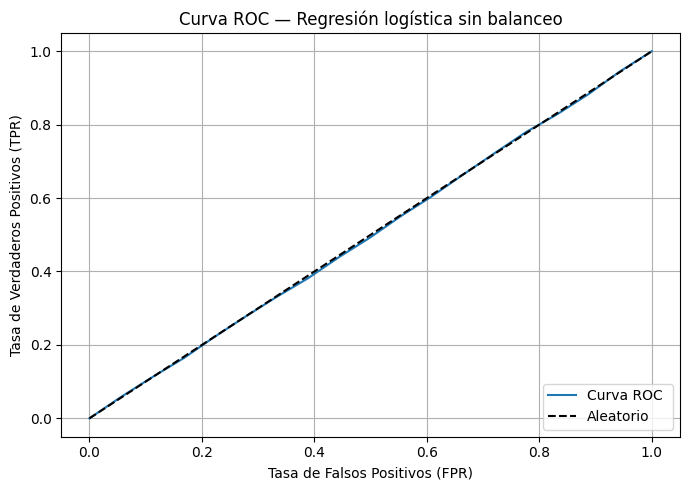

AUC (Área bajo la curva ROC): 0.4983


In [44]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Regresión logística sin balanceo')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

### 6.4 Modelo con balanceo por el método `ADASYN`

In [45]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"  # deja las numéricas igual
)
pipe=Pipeline([
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42, n_jobs=-1)),
    ("xgboost", XGBClassifier(random_state=42, tree_method='gpu_hist', use_label_encoder=False))  
])

param_grid_pipe={
    'xgboost__max_depth': [1, 2, 3, 4, 5],  # Rango para la profundidad del árbol
    'xgboost__learning_rate': [0.1, 0.2, 0.3],  # Rango para la tasa de aprendizaje
    'xgboost__n_estimators': [10, 50, 100],  # Número de árboles a entrenar
}

In [46]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1, verbose=1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Tiempo de ejecucion(segundos):837.05


In [47]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 1, 'xgboost__n_estimators': 10}
Best cross-validation score: 0.69


In [48]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.69      0.33      0.45     17524
    diseased       0.30      0.66      0.41      7476

    accuracy                           0.43     25000
   macro avg       0.49      0.49      0.43     25000
weighted avg       0.57      0.43      0.44     25000



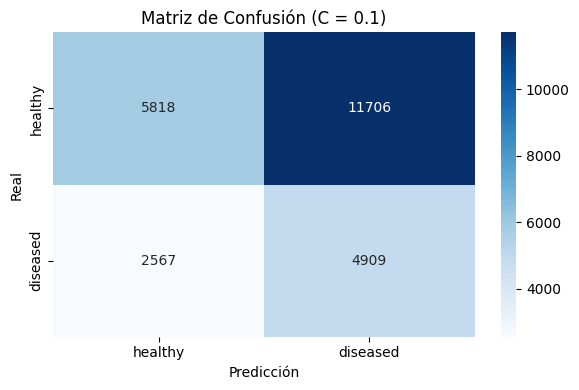

In [49]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

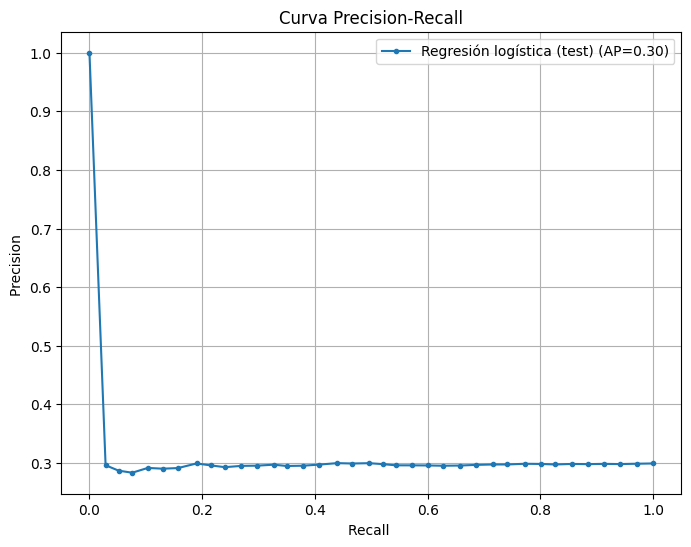

In [50]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'Regresión logística (test) (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

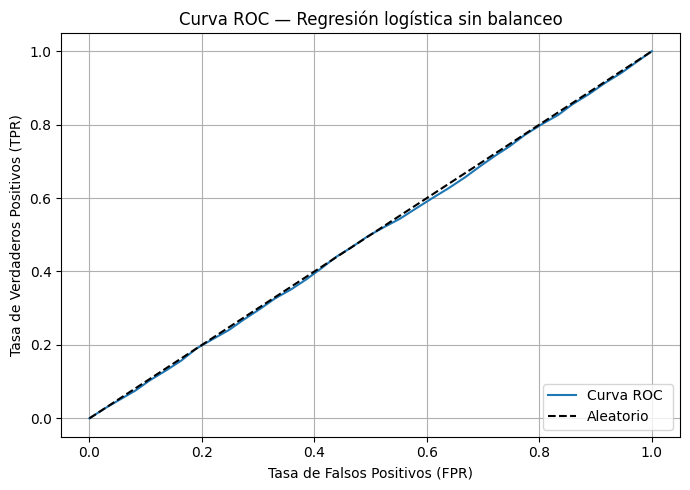

AUC (Área bajo la curva ROC): 0.4952


In [51]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Regresión logística sin balanceo')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")